# **Movie Recommendation System**

---------------
## **CONTEXT**
---------------
Online streaming platforms like Netflix have plenty of movies in their repository. And so, we can build a recommendation system to recommend relevant movies to users, based on their historical interactions. In doing so, we can improve customer satisfaction and hence, improve the revenue of the platform.

-----------------
## **OBJECTIVE**
-----------------
- Rank Based Recommendation System
- Similarity Based Collaborative Filtering
- Matrix Factorization Based Collaborative Filtering

-----------------
## **DATASET**
-----------------
- userId
- movieId
- rating
- timestamp

In [1]:
# For container datatypes
from collections import defaultdict 

# For array and dataframe computations
import numpy as np                              
import pandas as pd  

# For data visualization
import matplotlib.pyplot as plt               
import seaborn as sns     
sns.set_style("whitegrid")

# For recommendation systems
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBasic             # For similarity based recommender
from surprise.prediction_algorithms.matrix_factorization import SVD  # For model based recommender
from surprise import accuracy

import warnings                                 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ratings.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004** observations and **4** columns in the dataset.
- All the columns are of **numeric** data type.

In [4]:
df = df.drop(['timestamp'], axis=1)

In [5]:
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


## **Data Exploration**

### **Describe the distribution of ratings**

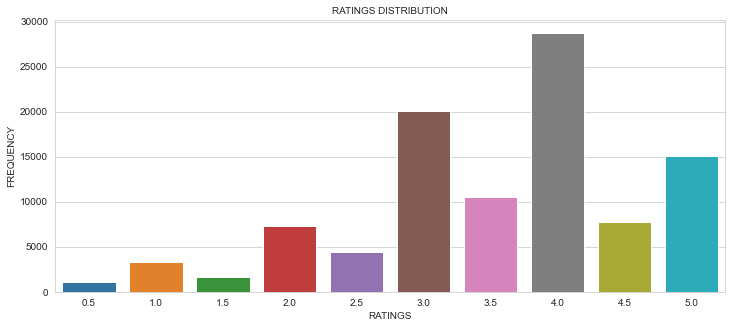

In [6]:
plt.figure(figsize = (12, 5))
sns.countplot(x=df.rating)
plt.tick_params(labelsize=10)
plt.title("RATINGS DISTRIBUTION", fontsize=10)
plt.xlabel("RATINGS", fontsize=10)
plt.ylabel("FREQUENCY", fontsize=10)
plt.show()

- The ratings with highest number of counts are 3 (20k), 4 (>25k), and 5 (15k), while the ratings with lowest number of counts are 0.5 (<5k), 1 (<5k), and 1.5 (<5k).
- The overall distribution seems to center around 3 - 4 stars, indicating that users tend to give the middle ratings.

### **Total number of unique users and movies**

In [7]:
df['userId'].nunique()

671

There're 671 unique users.

In [8]:
df['movieId'].nunique()

9066

There're 9066 unique movies.

### **Duplicated user-movie pairs**

In [9]:
# Total number of row count for each group
print((df.groupby(['userId', 'movieId']).size() > 1).sum())
print((df.groupby(['userId', 'movieId']).size()).sum())

0
100004


Each user-movie pair only returns one associated row, as can be validated by...
- The boolean array evaluates to all false.
- The sum is equal to the number of observations.

### **Most interacted movies**

In [10]:
df['movieId'].value_counts()[:5]

356    341
296    324
318    311
593    304
260    291
Name: movieId, dtype: int64

The movieId 356 has been interacted with users for 341 times. 

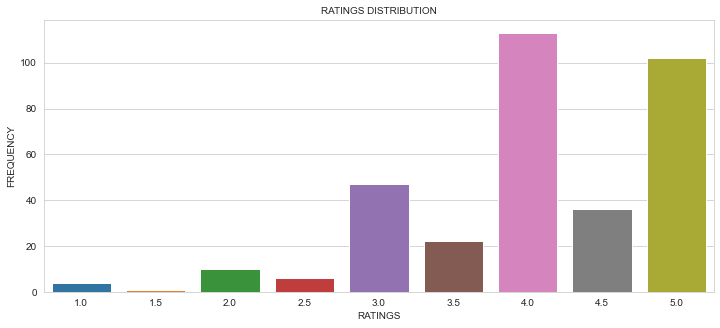

In [11]:
plt.figure(figsize = (12, 5))
sns.countplot(x=df[df['movieId'] == 356]['rating'])
plt.tick_params(labelsize=10)
plt.title("RATINGS DISTRIBUTION", fontsize=10)
plt.xlabel('RATINGS', fontsize=10)
plt.ylabel('FREQUENCY', fontsize=10)
plt.show()

From the ratings distribution, it shows that the movieId 356 has received mostly positive feedback, with the ratings 4 and 5 dominating the users opinion.  

### **Most interacted users**

In [12]:
df['userId'].value_counts()[:5]

547    2391
564    1868
624    1735
15     1700
73     1610
Name: userId, dtype: int64

The userId 547 has been engaged with movies for 2391 times. 

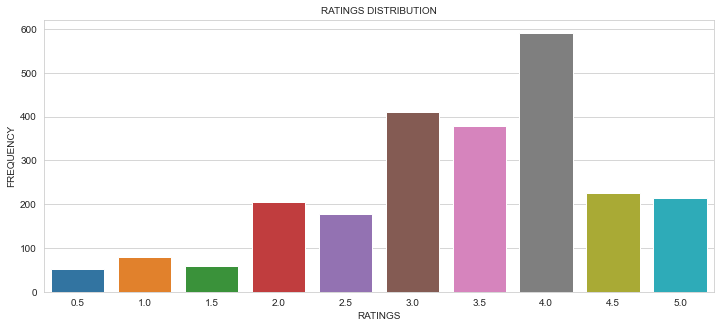

In [13]:
plt.figure(figsize = (12, 5))
sns.countplot(x=df[df['userId'] == 547]['rating'])
plt.tick_params(labelsize=10)
plt.title("RATINGS DISTRIBUTION", fontsize=10)
plt.xlabel('RATINGS', fontsize=10)
plt.ylabel('FREQUENCY', fontsize=10)
plt.show()

From the ratings distribution, it shows that the userId 547 has given mostly middle ratings (3 - 4).

### **Describe the distribution of user-movie interactions**

In [14]:
interactions = df.groupby('userId')['movieId'].size().sort_values()
interactions[::-1]

userId
547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
444      20
445      20
448      20
498      20
1        20
Name: movieId, Length: 671, dtype: int64

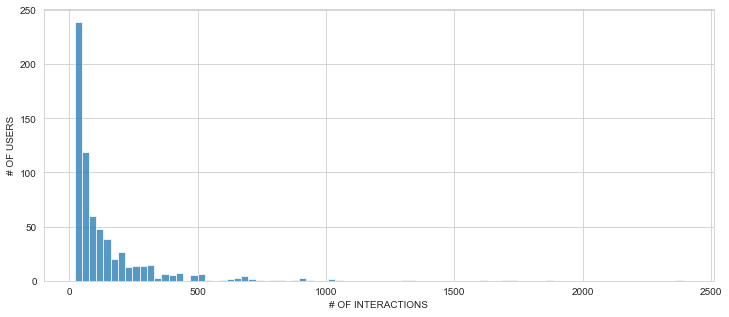

In [15]:
plt.figure(figsize = (12, 5))
sns.histplot(interactions)
plt.xlabel('# OF INTERACTIONS')
plt.ylabel('# OF USERS')
plt.show()

The distribution is highly skewed to the right, indicating that most of the users rate only a few movies, and in rare occasions, some users rate up to 1k movies.  

## **Recommendation System**

## **Recommendation Function**

Given a user, we'd like to provide the top n recommendations based on our model:
- Derive the user-item matrix
- Filter the non-interacted items 
- For each non-interacted item, predict its rating
- Across all items, recommend top n items

In [16]:
# Sparse Matrix
df.pivot(index='userId', columns='movieId', values='rating')

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Compressed Sparse Row Matrix
from scipy.sparse import csr_matrix
csr_matrix(df.pivot(index='userId', columns='movieId', values='rating')).toarray()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [ 5., nan, nan, ..., nan, nan, nan]])

In [18]:
def provide_recommendations(df, customer_id, reco_n, reco_model):
    
    recommendations = []
    
    interactions_matrix = df.pivot(index='userId', columns='movieId', values='rating')
    non_interacted_items = interactions_matrix.loc[customer_id][interactions_matrix.loc[customer_id].isnull()].index.tolist()
    
    for item_id in non_interacted_items:
        prediction = reco_model.predict(customer_id, item_id).est
        recommendations.append((item_id, prediction))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:reco_n]

## **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problems. 
- Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions. 
- In such cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system:
- Take the average ratings 
- Rank the obtained results 

In [19]:
mean_score = df.groupby('movieId')['rating'].mean()
size_n = df.groupby('movieId')['rating'].size()

df_final = pd.DataFrame({'mean_score': mean_score, 'size_n': size_n})
df_final.head()

,mean_score,size_n
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [20]:
def Top_N(df, n, min_interaction=100):
    
    # Filter movies with minimum number of interactions
    recommendations = df[df['size_n'] > min_interaction]
    # Sort movies with respect to mean score 
    recommendations = recommendations.sort_values(by='mean_score', ascending=False)
    
    return recommendations.index[:n]

**Top 5 recommendations with 50 minimum interactions**

In [21]:
list(Top_N(df=df_final, n=5, min_interaction=50))

[858, 318, 913, 1221, 50]

**Top 5 recommendations with 100 minimum interactions**

In [22]:
list(Top_N(df=df_final, n=5, min_interaction=100))

[858, 318, 1221, 50, 527]

**Top 5 recommendations with 200 minimum interactions**

In [23]:
list(Top_N(df=df_final, n=5, min_interaction=200))

[318, 50, 527, 608, 296]

## **Model 2: User-Based Collaborative Filtering Recommendation System**

### **Modelling Workflow**
1. Prepare Surprise Dataset
2. Build Baseline Model
3. Tune Model Hyperparameters
4. Make Final Recommendations

### **Baseline - User-User Similarity**

- Measure: Cosine Similarity
- Algorithm: K-Nearest Neighbors

In [24]:
reader = Reader(rating_scale=(0, 5))
surprise = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
TRAIN, TEST = train_test_split(surprise, test_size=0.2, random_state=42)

In [25]:
# Instantiate > Train > Evaluate
sim_options = {'name': 'cosine', 'user_based': True}
KNN_USER_USER = KNNBasic(sim_options=sim_options, verbose=False)
KNN_USER_USER.fit(TRAIN)

predictions = KNN_USER_USER.test(TEST)
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### **Score**

As can be seen from the output, the user-user baseline model has RMSE of 0.9925.

### **Prediction**

**userId=4, movieId=10**

In [26]:
KNN_USER_USER.predict(uid=4, iid=10, r_ui=4, verbose=False)

Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

Based on the user-user similarity model, the predicted rating is 3.62, while the actual rating is 4.

**userId=4, movieId=3**

In [27]:
KNN_USER_USER.predict(uid=4, iid=3, verbose=False)

Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

Based on the user-user similarity model, the predicted rating is 3.20 for the unwatched movieId 3.

### **Tuned - User-User Similarity**

- **k** (int):  
  - The maximum number of neighbors to take into account for aggregation
  - Default = 40
- **min_k** (int):
  - The minimum number of neighbors to take into account for aggregation
  - Default = 1
- **sim_options** (dict):
  - cosine
  - msd
  - pearson
  - pearson baseline

### **Hyperparameter Tuning**

In [28]:
# Use Grid-Search CV to choose the optimal hyperparameters
param_grid = {
    'k': [30, 40, 50],
    'min_k': [5, 10],
    'sim_options': {'name': ['pearson', 'cosine'], 'user_based': [True]}
}

grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid_obj.fit(surprise)

print(grid_obj.best_score['rmse'])
print(grid_obj.best_params['rmse'])

0.9926868919930331
{'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [29]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.003697,0.997840,0.992287,0.997941,0.004659,6,0.781579,0.772592,0.773864,0.776012,0.003971,9,0.686480,0.034866,4.870000,0.080062,"{'k': 30, 'min_k': 5, 'sim_options': {'name': ...",30,5,"{'name': 'pearson', 'user_based': True}"
1,0.999915,0.994161,0.985864,0.993314,0.005768,3,0.773609,0.766299,0.765886,0.768598,0.003548,1,0.415202,0.083791,4.943530,0.067708,"{'k': 30, 'min_k': 5, 'sim_options': {'name': ...",30,5,"{'name': 'cosine', 'user_based': True}"
2,1.008289,1.007151,0.998466,1.004635,0.004387,12,0.786676,0.780676,0.779680,0.782344,0.003090,12,0.493044,0.077887,4.999586,0.195549,"{'k': 30, 'min_k': 10, 'sim_options': {'name':...",30,10,"{'name': 'pearson', 'user_based': True}"
3,1.005701,1.000702,0.994234,1.000212,0.004694,9,0.779218,0.771805,0.772448,0.774491,0.003353,4,0.417654,0.000891,4.541776,0.076840,"{'k': 30, 'min_k': 10, 'sim_options': {'name':...",30,10,"{'name': 'cosine', 'user_based': True}"
4,1.003147,0.997299,0.991674,0.997374,0.004684,5,0.781222,0.772074,0.773493,0.775596,0.004020,8,0.565860,0.011894,4.607016,0.085404,"{'k': 40, 'min_k': 5, 'sim_options': {'name': ...",40,5,"{'name': 'pearson', 'user_based': True}"


In [30]:
# Instantiate > Train > Evaluate
KNN_USER_USER_optimized = KNNBasic(k=grid_obj.best_params['rmse']['k'], 
                                   min_k=grid_obj.best_params['rmse']['min_k'], 
                                   sim_options=grid_obj.best_params['rmse']['sim_options'], 
                                   verbose=False)
KNN_USER_USER_optimized.fit(TRAIN)

predictions = KNN_USER_USER_optimized.test(TEST)
accuracy.rmse(predictions)

RMSE: 0.9901


0.9900753719644309

As can be seen from the output, the user-user tuned model has RMSE of 0.9901, which is slightly better than the previous 0.9925.

### **Prediction**

**userId=4, movieId=10**

In [31]:
KNN_USER_USER_optimized.predict(uid=4, iid=10, r_ui=4, verbose=False)

Prediction(uid=4, iid=10, r_ui=4, est=3.530256666415297, details={'actual_k': 50, 'was_impossible': False})

Based on the user-user similarity model, the predicted rating is 3.53, which is no better than the previous 3.62. 

**userId=4, movieId=3**

In [32]:
KNN_USER_USER_optimized.predict(uid=4, iid=3, verbose=False)

Prediction(uid=4, iid=3, r_ui=None, est=3.0392765787355085, details={'actual_k': 48, 'was_impossible': False})

Based on the user-user similarity model, the predicted rating is 3.03 for the unwatched movieId 3, which is slightly lower than the previous 3.20.

### **K Nearest Neighbors**

In [33]:
KNN_USER_USER_optimized.get_neighbors(iid=4, k=5)

[357, 220, 590, 491, 647]

### **Recommendations**

In [34]:
recommendations = provide_recommendations(df=df, customer_id=4, reco_n=5, reco_model=KNN_USER_USER_optimized)
recommendations

[(98491, 4.832340578646058),
 (116, 4.753206589295344),
 (6669, 4.748048450384675),
 (178, 4.699972510945085),
 (7116, 4.698337052222263)]

## **Model 3: Item-Based Collaborative Filtering Recommendation System**

### **Baseline - Item-Item Similarity**

In [35]:
# Instantiate > Train > Evaluate
sim_options = {'name': 'cosine', 'user_based': False}
KNN_ITEM_ITEM = KNNBasic(sim_options=sim_options, verbose=False)
KNN_ITEM_ITEM.fit(TRAIN)

predictions = KNN_ITEM_ITEM.test(TEST)
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

### **Score**

As can be seen from the output, the item-item baseline model has RMSE of 1.0032.

### **Prediction**

**userId=4, movieId=10**

In [36]:
KNN_ITEM_ITEM.predict(uid=4, iid=10, r_ui=4, verbose=False)

Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

Based on the item-item similarity model, the predicted rating is 4.37, while the actual rating is 4.

**userId=4, movieId=3**

In [37]:
KNN_ITEM_ITEM.predict(uid=4, iid=3, verbose=False)

Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

Based on the item-item similarity model, the predicted rating is 4.07 for the unwatched movieId 3.

### **Tuned - Item-Item Similarity**

### **Hyperparameter Tuning**

In [38]:
# Use Grid-Search CV to choose the optimal hyperparameters
param_grid = {
    'k': [30, 40, 50],
    'min_k': [5, 10, 15],
    'sim_options': {'name': ['pearson', 'cosine'], 'user_based': [False]}
}

grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid_obj.fit(surprise)

print(grid_obj.best_score['rmse'])
print(grid_obj.best_params['rmse'])

0.9853900096276677
{'k': 50, 'min_k': 5, 'sim_options': {'name': 'pearson', 'user_based': False}}


In [39]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.992792,0.996070,0.991569,0.993477,0.001900,10,0.770000,0.774023,0.770968,0.771664,0.001714,9,31.249009,0.387966,22.821637,0.277182,"{'k': 30, 'min_k': 5, 'sim_options': {'name': ...",30,5,"{'name': 'pearson', 'user_based': False}"
1,1.001681,0.999912,1.000560,1.000718,0.000731,16,0.780479,0.778672,0.779788,0.779646,0.000745,16,12.370301,5.467715,25.167552,1.717683,"{'k': 30, 'min_k': 5, 'sim_options': {'name': ...",30,5,"{'name': 'cosine', 'user_based': False}"
2,0.994395,0.996438,0.994072,0.994968,0.001047,13,0.772779,0.775691,0.774507,0.774326,0.001195,12,13.214802,3.638203,21.367029,0.435640,"{'k': 30, 'min_k': 10, 'sim_options': {'name':...",30,10,"{'name': 'pearson', 'user_based': False}"
3,1.001437,1.001197,1.001807,1.001480,0.000251,17,0.780333,0.779800,0.780563,0.780232,0.000320,17,6.464274,0.426525,23.082370,0.986075,"{'k': 30, 'min_k': 10, 'sim_options': {'name':...",30,10,"{'name': 'cosine', 'user_based': False}"
4,0.998068,0.999165,0.997507,0.998247,0.000689,15,0.778154,0.780166,0.779647,0.779323,0.000853,15,12.768310,1.852909,26.030743,0.814725,"{'k': 30, 'min_k': 15, 'sim_options': {'name':...",30,15,"{'name': 'pearson', 'user_based': False}"


In [40]:
# Instantiate > Train > Evaluate
KNN_ITEM_ITEM_optimized = KNNBasic(k=grid_obj.best_params['rmse']['k'], 
                                   min_k=grid_obj.best_params['rmse']['min_k'], 
                                   sim_options=grid_obj.best_params['rmse']['sim_options'], 
                                   verbose=False)
KNN_ITEM_ITEM_optimized.fit(TRAIN)

predictions = KNN_ITEM_ITEM_optimized.test(TEST)
accuracy.rmse(predictions)

RMSE: 0.9902


0.9902304322662595

As can be seen from the output, the item-item tuned model has RMSE of 0.9902, which is slightly better than the previous 1.0032.

### **Prediction**

**userId=4, movieId=10**

In [41]:
KNN_ITEM_ITEM_optimized.predict(uid=4, iid=10, r_ui=4, verbose=False)

Prediction(uid=4, iid=10, r_ui=4, est=4.377003466107858, details={'actual_k': 50, 'was_impossible': False})

Based on the item-item similarity model, the predicted rating is 4.377, which is almost the same with the previous 4.373.

**userId=4, movieId=3**

In [42]:
KNN_ITEM_ITEM_optimized.predict(uid=4, iid=3, verbose=False)

Prediction(uid=4, iid=3, r_ui=None, est=4.0957082898049375, details={'actual_k': 50, 'was_impossible': False})

Based on the item-item similarity model, the predicted rating is 4.09 for the unwatched movieId 3, which is almost the same with the previous 4.07.

### **K Nearest Neighbors**

In [43]:
KNN_ITEM_ITEM_optimized.get_neighbors(iid=4, k=5)

[3, 12, 33, 61, 75]

### **Recommendations**

In [44]:
recommendations = provide_recommendations(df=df, customer_id=4, reco_n=5, reco_model=KNN_ITEM_ITEM_optimized)
recommendations

[(37, 5), (68, 5), (154, 5), (269, 5), (331, 5)]

## **Model 4: Model-Based Collaborative Filtering Recommendation System**

### **Singular Value Decomposition (SVD)**

- Computes the latent features from the user-item matrix
- Does not work when missing values are present in the matrix 
- Decomposition (n: Users, m: Items, k: Latent Features):
  - U matrix (n * k)
  - Sigma matrix (k * k)
  - V transpose matrix (k * m)

### **Baseline - Matrix Factorization**

In [45]:
# Instantiate > Train > Evaluate
MF_USER_ITEM = SVD()
MF_USER_ITEM.fit(TRAIN)

predictions = MF_USER_ITEM.test(TEST)
accuracy.rmse(predictions)

RMSE: 0.9011


0.9010587817257045

### **Score**

As can be seen from the output, the user-item baseline model has RMSE of 0.9011.

### **Prediction**

**userId=4, movieId=10**

In [46]:
MF_USER_ITEM.predict(uid=4, iid=10, r_ui=4, verbose=False)

Prediction(uid=4, iid=10, r_ui=4, est=3.9537167508065068, details={'was_impossible': False})

Based on the user-item similarity model, the predicted rating is 3.95, while the actual rating is 4.

**userId=4, movieId=3**

In [47]:
MF_USER_ITEM.predict(uid=4, iid=3, verbose=False)

Prediction(uid=4, iid=3, r_ui=None, est=3.8873139661358236, details={'was_impossible': False})

Based on the user-item similarity model, the predicted rating is 3.88 for the unwatched movieId 3.

### **Tuned - Matrix Factorization**

To make prediction:

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

- _If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero._
- _If item $i$ is unknown, then the bias $b_{i}$ and the factors $q_{i}$ are assumed to be zero._

To estimate all the unknown, we minimize the regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **Stochastic Gradient Descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

Some of the hyperparameters are:
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### **Hyperparameter Tuning**

In [48]:
# Use Grid-Search CV to choose the optimal hyperparameters
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30], 
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

grid_obj = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid_obj.fit(surprise)

print(grid_obj.best_score['rmse'])
print(grid_obj.best_params['rmse'])

0.8928713513778416
{'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [49]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
0,0.947318,0.939267,0.938527,0.941704,0.003981,73,0.741294,0.732447,0.737568,0.737103,...,73,0.559676,0.026104,1.131895,0.092414,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",50,10,0.001,0.2
1,0.952929,0.944260,0.943590,0.946926,0.004253,76,0.747210,0.737987,0.743010,0.742736,...,76,0.584021,0.109923,1.069749,0.137123,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",50,10,0.001,0.4
2,0.958082,0.949680,0.949425,0.952396,0.004022,79,0.752736,0.744136,0.749020,0.748631,...,79,0.609424,0.084781,1.279236,0.169951,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",50,10,0.001,0.6
3,0.912458,0.903749,0.902350,0.906186,0.004472,28,0.705836,0.697462,0.701805,0.701701,...,25,0.735424,0.068748,1.455147,0.018412,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",50,10,0.005,0.2
4,0.919953,0.911177,0.909942,0.913691,0.004457,43,0.714046,0.705552,0.709798,0.709799,...,43,0.674295,0.021404,1.275503,0.065929,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",50,10,0.005,0.4


In [50]:
# Instantiate > Train > Evaluate
MF_USER_ITEM_optimized = SVD(n_factors=grid_obj.best_params['rmse']['n_factors'],
                             n_epochs=grid_obj.best_params['rmse']['n_epochs'], 
                             lr_all=grid_obj.best_params['rmse']['lr_all'], 
                             reg_all=grid_obj.best_params['rmse']['reg_all'],
                             verbose=False)
MF_USER_ITEM_optimized.fit(TRAIN)

predictions = MF_USER_ITEM_optimized.test(TEST)
accuracy.rmse(predictions)

RMSE: 0.8952


0.8951922244467413

As can be seen from the output, the user-item tuned model has RMSE of 0.8952, which is slightly better than the previous 0.9011.

### **Prediction**

**userId=4, movieId=10**

In [51]:
MF_USER_ITEM_optimized.predict(uid=4, iid=10, r_ui=4, verbose=False)

Prediction(uid=4, iid=10, r_ui=4, est=3.9868445179994896, details={'was_impossible': False})

Based on the user-item similarity model, the predicted rating is 3.98, which is slightly better than the previous 3.95.

**userId=4, movieId=3**

In [52]:
MF_USER_ITEM_optimized.predict(uid=4, iid=3, verbose=False)

Prediction(uid=4, iid=3, r_ui=None, est=3.656513102443013, details={'was_impossible': False})

Based on the user-item similarity model, the predicted rating is 3.65 for the unwatched movieId 3, which is slightly lower than the previous 3.88.

### **Recommendations**

In [53]:
recommendations = provide_recommendations(df=df, customer_id=4, reco_n=5, reco_model=MF_USER_ITEM_optimized)
recommendations

[(1192, 4.993365658624584),
 (926, 4.957438050768057),
 (116, 4.9469817985303175),
 (3310, 4.929791829095603),
 (1948, 4.927905456811588)]

## **Model Evaluation - Ratings Difference** 

Given a user, we'd like to compare the true rating with the predicted rating:
- Derive the user-item matrix
- Filter the interacted items
- For each interacted item, get its actual rating and predicted rating
- Across all items, sort by actual ratings in descending order 

In [54]:
def evaluate_prediction_results(df, customer_id, reco_model):
    
    recommendations = []
    
    interactions_matrix = df.pivot(index='userId', columns='movieId', values='rating')
    interacted_items = interactions_matrix.loc[customer_id][interactions_matrix.loc[customer_id].notnull()].index.tolist()
    
    for item_id in interacted_items:
        actual_score = interactions_matrix.loc[customer_id, item_id]
        predicted_score = reco_model.predict(customer_id, item_id).est
        recommendations.append((item_id, actual_score, predicted_score))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    recommendations_df = pd.DataFrame(recommendations, columns=['movieId', 'actual_score', 'predicted_score']) 

    return recommendations_df

**Similarity Based Recommendation System**

     movieId         variable     value
127        1  predicted_score  3.578433
39         1     actual_score  3.000000
128       10  predicted_score  3.234267
40        10     actual_score  3.000000
129       21  predicted_score  3.282035
41        21     actual_score  3.000000


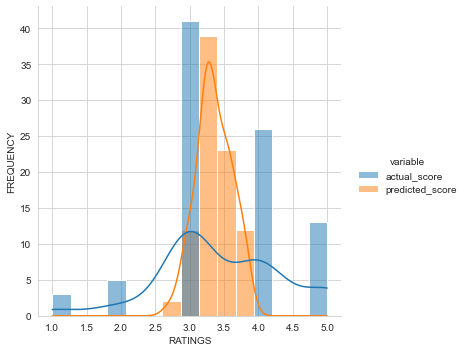

In [55]:
prediction_for_interacted_items = evaluate_prediction_results(df=df, customer_id=7, reco_model=KNN_ITEM_ITEM_optimized)
melted_df = prediction_for_interacted_items.melt(id_vars='movieId', value_vars=['actual_score', 'predicted_score'])
print(melted_df.sort_values('movieId').head(6))

sns.displot(data=melted_df, x='value', hue='variable', kde=True)
plt.xlabel('RATINGS')
plt.ylabel('FREQUENCY');

Through the comparisons between predicted ratings and actual ratings, we observe that:
- The actual ratings are discrete values, whereas the predicted ratings are on the continuous scale, as the prediction is based on the aggregated ratings from the nearest neighbors.
- The shape of the two distributions are somewhat close to each other, although not exactly the same, with most of the ratings centering around 3 - 4. 

**Model Based Recommendation System**

     movieId         variable     value
127        1  predicted_score  3.588940
39         1     actual_score  3.000000
128       10  predicted_score  3.257465
40        10     actual_score  3.000000
129       21  predicted_score  3.372015
41        21     actual_score  3.000000


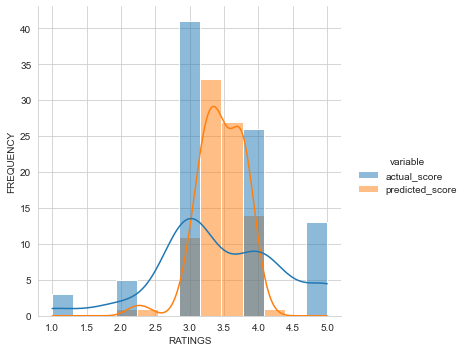

In [56]:
prediction_for_interacted_items = evaluate_prediction_results(df=df, customer_id=7, reco_model=MF_USER_ITEM_optimized)
melted_df = prediction_for_interacted_items.melt(id_vars='movieId', value_vars=['actual_score', 'predicted_score'])
print(melted_df.sort_values('movieId').head(6))

sns.displot(data=melted_df, x='value', hue='variable', kde=True)
plt.xlabel('RATINGS')
plt.ylabel('FREQUENCY');

Through the comparisons between predicted ratings and actual ratings, we observe that:
- The actual ratings are discrete values, whereas the predicted ratings are on the continuous scale, as the prediction is based on the aggregated ratings from the nearest neighbors.
- The shape of the two distributions are much close to each other in Matrix-Factorization Model, capturing the two modes/peaks of the user ratings. 

## **Model Evaluation - Confusion Matrix**

Metrics:
- **Precision@k**
  - Fraction of recommended items that are relevant in top k predictions
  - k: The number of recommendations to be provided to the user
- **Recall@k**
  - Fraction of relevant items that are recommended in top k predictions
  - k: The number of recommendations to be provided to the user

Reference: 
- https://surprise.readthedocs.io/en/stable/FAQ.html
- https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

In [57]:
reader = Reader(rating_scale=(0, 5))
surprise = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
TRAIN, TEST = train_test_split(surprise, test_size=0.2, random_state=42)

In [58]:
# Function can be found on surprise documentation FAQs

def precision_recall_at_k(prediction, k=10, critical_val=3.5):

    customer_res = defaultdict(list)
    for customer_id, _, TRUE, PRED, _ in prediction:
        customer_res[customer_id].append((PRED, TRUE))

    precisions = dict()
    recalls = dict()
    for customer_id, res in customer_res.items():

        res.sort(key=lambda x: x[0], reverse=True)

        # RELEVANT ITEMS
        n_rel = sum((TRUE >= critical_val) for (_, TRUE) in res)

        # RECOMMENDED ITEMS
        n_rec_k = sum((PRED >= critical_val) for (PRED, _) in res[:k])

        # RELEVANT ITEMS + RECOMMENDED ITEMS
        n_rel_and_rec_k = sum(((TRUE >= critical_val) and (PRED >= critical_val)) for (PRED, TRUE) in res[:k])

        # PRECISION
        precisions[customer_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # RECALL
        recalls[customer_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [59]:
kf = KFold(n_splits=5)     # Five Folds
n_reco = [5, 10]           # K Recommendations

model_objs = {
    'KNN_USER_USER': KNN_USER_USER,
    'KNN_USER_USER_optimized': KNN_USER_USER_optimized,
    'KNN_ITEM_ITEM': KNN_ITEM_ITEM,
    'KNN_ITEM_ITEM_optimized': KNN_ITEM_ITEM_optimized,
    'MF_USER_ITEM': MF_USER_ITEM,
    'MF_USER_ITEM_optimized': MF_USER_ITEM_optimized
}

model_perf = {}
for n in n_reco:
    
    model_perf[n] = {}
    
    for model_name, model_obj in model_objs.items():
        
        print('> k={}, model={}'.format(n, model_obj.__class__.__name__))

        p = []
        r = []
        rmse = []
        for TRAIN, TEST in kf.split(surprise):
            
            model_obj.fit(TRAIN)
            predictions = model_obj.test(TEST, verbose=False)
            
            model_rmse = accuracy.rmse(predictions)
            rmse.append(model_rmse)
            
            # INDIVIDUAL USER
            precisions, recalls = precision_recall_at_k(predictions, k=n, critical_val=3.5)
            # ALL USERS
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('=====> Mean Precision:', round(sum(p) / len(p), 3))
        print('=====> Mean Recall:', round(sum(r) / len(r), 3))
        print('=====> Mean RMSE:', round(sum(rmse) / len(rmse), 3))
        
        model_perf[n][model_name] = [
            round(sum(p) / len(p), 3), 
            round(sum(r) / len(r), 3),
            round(sum(rmse) / len(rmse), 3)
        ]

> k=5, model=KNNBasic
RMSE: 0.9940
RMSE: 0.9986
RMSE: 0.9857
RMSE: 0.9933
RMSE: 0.9960
=====> Mean Precision: 0.769
=====> Mean Recall: 0.413
=====> Mean RMSE: 0.994
> k=5, model=KNNBasic
RMSE: 0.9824
RMSE: 0.9824
RMSE: 0.9839
RMSE: 0.9889
RMSE: 0.9974
=====> Mean Precision: 0.772
=====> Mean Recall: 0.42
=====> Mean RMSE: 0.987
> k=5, model=KNNBasic
RMSE: 0.9914
RMSE: 0.9959
RMSE: 0.9886
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity mat

RMSE: 0.9867
RMSE: 0.9953
RMSE: 0.9948
RMSE: 0.9994
RMSE: 0.9954
=====> Mean Precision: 0.597
=====> Mean Recall: 0.477
=====> Mean RMSE: 0.994
> k=10, model=KNNBasic
RMSE: 0.9898
RMSE: 0.9841
RMSE: 0.9870
RMSE: 0.9719
RMSE: 0.9864
=====> Mean Precision: 0.631
=====> Mean Recall: 0.477
=====> Mean RMSE: 0.984
> k=10, model=SVD
RMSE: 0.8966
RMSE: 0.8985
RMSE: 0.8872
RMSE: 0.8940
RMSE: 0.9046
=====> Mean Precision: 0.733
=====> Mean Recall: 0.519
=====> Mean RMSE: 0.896
> k=10, model=SVD
RMSE: 0.8902
RMSE: 0.9010
RMSE: 0.8872
RMSE: 0.8874
RMSE: 0.8842
=====> Mean Precision: 0.728
=====> Mean Recall: 0.522
=====> Mean RMSE: 0.89


In [60]:
model_perf

{5: {'KNN_USER_USER': [0.769, 0.413, 0.994],
  'KNN_USER_USER_optimized': [0.772, 0.42, 0.987],
  'KNN_ITEM_ITEM': [0.608, 0.329, 0.994],
  'KNN_ITEM_ITEM_optimized': [0.64, 0.339, 0.986],
  'MF_USER_ITEM': [0.751, 0.382, 0.896],
  'MF_USER_ITEM_optimized': [0.744, 0.385, 0.89]},
 10: {'KNN_USER_USER': [0.747, 0.547, 0.993],
  'KNN_USER_USER_optimized': [0.749, 0.559, 0.986],
  'KNN_ITEM_ITEM': [0.597, 0.477, 0.994],
  'KNN_ITEM_ITEM_optimized': [0.631, 0.477, 0.984],
  'MF_USER_ITEM': [0.733, 0.519, 0.896],
  'MF_USER_ITEM_optimized': [0.728, 0.522, 0.89]}}

In [61]:
comp_df = pd.DataFrame.from_dict(model_perf)

for col in comp_df.columns:
    comp_df[f'mean_precision_k{col}'] = comp_df[col].apply(lambda x: x[0])
    comp_df[f'mean_recall_k{col}'] = comp_df[col].apply(lambda x: x[1])
    comp_df[f'mean_rmse_k{col}'] = comp_df[col].apply(lambda x: x[2])

comp_df['mean_rmse'] = (comp_df['mean_rmse_k5'] + comp_df['mean_rmse_k10']) / 2
comp_df.drop([5, 10, 'mean_rmse_k5', 'mean_rmse_k10'], axis=1)

,mean_precision_k5,mean_recall_k5,mean_precision_k10,mean_recall_k10,mean_rmse
KNN_USER_USER,0.769,0.413,0.747,0.547,0.9935
KNN_USER_USER_optimized,0.772,0.420,0.749,0.559,0.9865
KNN_ITEM_ITEM,0.608,0.329,0.597,0.477,0.9940
KNN_ITEM_ITEM_optimized,0.640,0.339,0.631,0.477,0.9850
MF_USER_ITEM,0.751,0.382,0.733,0.519,0.8960
MF_USER_ITEM_optimized,0.744,0.385,0.728,0.522,0.8900


### **Compare the results from the baseline user-user and item-item models**
From the K-Fold Cross-Validation model evaluation outputs, we can observe that:
- Using precision and recall: KNN USER-USER model outperforms KNN ITEM-ITEM model.
- Using rmse: KNN USER-USER model (RMSE=0.9935) also outperforms KNN ITEM-ITEM model (RMSE=0.9940).

### **Compare the results from the tuned user-user and item-item models**
- KNN USER-USER model: 
  - In terms of RMSE, the tuned model performs better than the baseline model (0.9865 < 0.9935).
  - In terms of precision and recall, the tuned model has higher recall than the baseline model, indicating that the tuned model is able to recommend more relevant movies.
- KNN ITEM-ITEM model:
  - In terms of RMSE, the tuned model performs better than the baseline model (0.9850 < 0.9940).
  - In terms of precision and recall, the tuned model has higher precision and recall than the baseline model.
- Comparison: Although the tuned KNN ITEM-ITEM model has lower RMSE than the tuned KNN USER-USER model (0.9850 < 0.9865), the KNN USER-USER model has higher recall and precision than the KNN ITEM-ITEM model. 

### **Final remarks**

#### **Describe the difference between Matrix Factorization and Collaborative Filtering**
- Collaborative Filtering: Based on the similarity between users or items, the K-Nearest-Neighbors algorithm tries to recommend items that similar users like or that similar items share.   
- Matrix Factorization: Given the user-item interaction matrix, the Matrix-Factorization algorithm tries to decompose the original matrix into the product of lower-dimensional matrices, with the aim of extracting the latent features.

#### **Compare the model performance (RMSE, Precision, Recall)**
- MF USER-ITEM model achieves the lowest RMSE of around 0.89.
- MF USER-ITEM model has higher precision and recall than KNN ITEM-ITEM model, but lower precision and recall than KNN USER-USER model.